<a id='topo'></a>

# [MobileNet - (128x128)](#sem_imagenet)
- rede alterada para grayscale (Input com 1 channel)
- realizado resize das imagens para 128x128
- fit com 10 epochs


# [MobileNet - (128x128) Pesos imagenet](#pesos_imagenet)
- rede alterada para grayscale (Input com 1 channel)
- realizado resize das imagens para 128x128
- fit com 10 epochs
- adicionados pesos imagenet e camadas finais (include_top = True)

/home/camilalm/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Samples shape: (2062, 64, 64)
Labels shape: (2062, 10)

Training shape: (1752, 64, 64)
1752 sample, 64 x 64 size grayscale image.



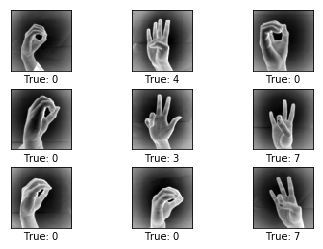

Test shape: (310, 64, 64)
310 sample, 64 x 64 size grayscale image.



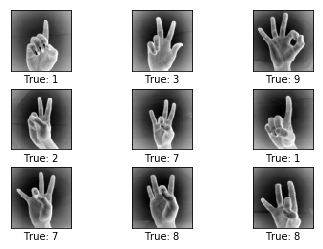

In [1]:
# Configura conjuntos de treinamento e teste 
# X_train, X_test, Y_train, Y_test
%run './functions/SLD-LoadTrainTestSets.ipynb'

In [2]:
import keras
from keras import backend as K
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Model, Input
from keras.applications.mobilenet import MobileNet
from keras.layers import Conv2D, GlobalAveragePooling2D, Reshape
from keras.optimizers import Adam

In [3]:
X_train = np.array(resize_npy_images(X_train, (128, 128)))
X_test = np.array(resize_npy_images(X_test, (128, 128)))

In [4]:
print('Training shape:', X_train.shape)
print('Test shape:', X_test.shape)

Training shape: (1752, 128, 128)
Test shape: (310, 128, 128)


In [5]:
original_input_shape = (128, 128, 3)
desired_input_shape = (128, 128, 1)
layer_name = 'conv1'

weights = None
include_top = False

adam_lr = 0.0001
nb_epochs = 10
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
validation_split = 0.1
batch_size=10

---

<a id='sem_imagenet'></a>

# Rede sem pesos ImageNet e sem Include top

[Voltar para topo](#topo)

In [6]:
base_model = MobileNet(input_shape=original_input_shape,
                       weights=weights,
                       include_top=include_top)
base_model.layers[-1].name

'conv_pw_13_relu'

In [7]:
# Alterando input para grayscale (1 channel)
selected_layer = base_model.get_layer(layer_name)
selected_layer_index = base_model.layers.index(selected_layer)

w = selected_layer.get_weights()
w[0] = w[0].mean(axis=2, keepdims=True)

y = x = Input(shape=desired_input_shape)

attributes = dict(selected_layer.get_config(),
                  name=layer_name + '_1',
                  weights=w)
selected_layer = Conv2D.from_config(attributes)

y = selected_layer(y)

for layer in base_model.layers[selected_layer_index + 1:]:
    y = layer(y)

In [8]:
# Adicionando camadas representadas pelo include_top=True
# camada FC no final da rede
y = GlobalAveragePooling2D()(y)
y = Reshape((1, 1, 1024))(y)
y = Dropout(0.25)(y)
y = Conv2D(10, kernel_size=(1, 1), activation='relu')(y)
y = Activation('softmax')(y)
y = Reshape((10,))(y)

In [9]:
model = Model(inputs=x, outputs=y)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 63, 63, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization multiple                  128       
_________________________________________________________________
conv1_relu (Activation)      multiple                  0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   multiple                  0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  multiple                  288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza multiple                  128       
__________

In [10]:
expand_train_X = np.expand_dims(X_train, axis=-1)
expand_test_X = np.expand_dims(X_test, axis=-1)

Train on 1576 samples, validate on 176 samples
Epoch 1/10
1576/1576 [==============================] - 115s 73ms/step - loss: 2.2784 - acc: 0.1377 - val_loss: 3.4090 - val_acc: 0.1193
Epoch 2/10
1576/1576 [==============================] - 111s 70ms/step - loss: 2.1962 - acc: 0.1954 - val_loss: 2.4134 - val_acc: 0.1761
Epoch 3/10
1576/1576 [==============================] - 114s 72ms/step - loss: 2.0484 - acc: 0.2728 - val_loss: 2.2060 - val_acc: 0.2614
Epoch 4/10
1576/1576 [==============================] - 114s 72ms/step - loss: 1.9014 - acc: 0.3344 - val_loss: 1.9917 - val_acc: 0.2955
Epoch 5/10
1576/1576 [==============================] - 115s 73ms/step - loss: 1.7369 - acc: 0.4036 - val_loss: 2.6651 - val_acc: 0.2102
Epoch 6/10
1576/1576 [==============================] - 119s 75ms/step - loss: 1.5522 - acc: 0.4721 - val_loss: 1.5751 - val_acc: 0.4318
Epoch 7/10
1576/1576 [==============================] - 114s 72ms/step - loss: 1.3689 - acc: 0.5260 - val_loss: 1.6106 - val_acc: 0

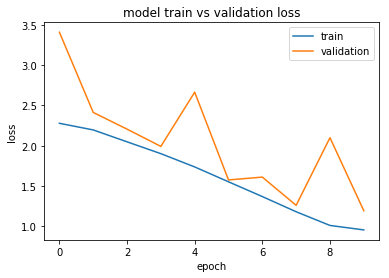

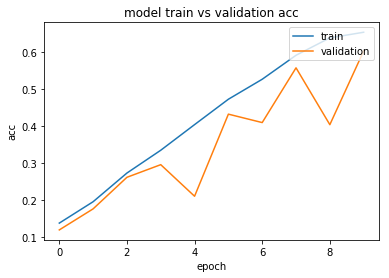

Acertos: 173 / 310
Confusion matrix, without normalization
[[30  0  0  0  0  0  0  0  0  2]
 [ 2 19  0  0  0  0  0  3  0  0]
 [ 0  5  0  0  0  0  0  2  1 26]
 [ 0  0  0 29  0  0  0  0  0  1]
 [ 1  0  0  1  0  3  0 10  4 11]
 [ 0  0  0  2  0 29  0  1  1  2]
 [ 2  0  0  0  0  0  0  2  3 21]
 [ 0  0  0  0  0  0  0 31  5  6]
 [ 0  0  0  0  0  0  0  5 19  4]
 [ 0  0  0  0  0  2  0  0  9 16]]
CPU times: user 1h 44min 21s, sys: 9min 26s, total: 1h 53min 47s
Wall time: 19min 34s


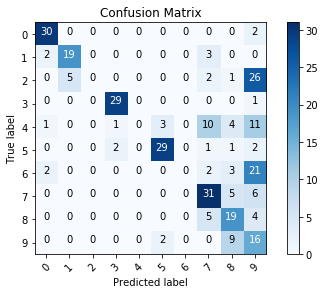

In [11]:
%%time
acertos, pred = execute_model(model, expand_train_X, Y_train, expand_test_X, Y_test,
                              validation_split, batch_size, cm_plot_labels, 
                              adam_lr, nb_epochs)

---

<a id='pesos_imagenet'></a>

# Rede com pesos ImageNet e com Include top

[Voltar para topo](#topo)

In [ ]:
weights = 'imagenet'
include_top = True

In [ ]:
base_model = MobileNet(input_shape=original_input_shape,
                       weights=weights,
                       include_top=include_top)
base_model.layers[-1].name

In [ ]:
base_model.summary()

In [ ]:
# Alterando input para grayscale (1 channel)
selected_layer = base_model.get_layer(layer_name)
selected_layer_index = base_model.layers.index(selected_layer)

w = selected_layer.get_weights()
w[0] = w[0].mean(axis=2, keepdims=True)

y = x = Input(shape=desired_input_shape)

attributes = dict(selected_layer.get_config(),
                  name=layer_name + '_1',
                  weights=w)
selected_layer = Conv2D.from_config(attributes)

y = selected_layer(y)

for layer in base_model.layers[selected_layer_index + 1:-4]:
    y = layer(y)

In [ ]:
# Adicionando camadas representadas pelo include_top=True
# camada FC no final da rede
# y = GlobalAveragePooling2D()(y)
# y = Reshape((1, 1, 1024))(y)
y = Dropout(0.25)(y)
y = Conv2D(10, kernel_size=(1, 1), activation='relu')(y)
y = Activation('softmax')(y)
y = Reshape((10,))(y)

In [ ]:
model = Model(inputs=x, outputs=y)
model.summary()

In [ ]:
# Congela camadas
# for layer in model.layers:
#     layer.trainable = False

In [ ]:
expand_train_X = np.expand_dims(X_train, axis=-1)
expand_test_X = np.expand_dims(X_test, axis=-1)

In [ ]:
%%time
acertos, pred = execute_model(model, expand_train_X, Y_train, expand_test_X, Y_test,
                              validation_split, batch_size, cm_plot_labels, 
                              adam_lr, nb_epochs)

---

In [ ]:
307/310

[Voltar para topo](#topo)

# Cria arquivo h5 com modelo da CNN

In [ ]:
model.save('SLD_MOBILENET_IMAGENET_CNN.h5')